# **Start**

In [1]:
# --- STEP 1: Import Libraries and Mount Drive ---
import numpy as np
import joblib
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

2025-06-25 11:42:29.067861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750851749.271744      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750851749.331600      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

# --- STEP 2: Configuration - Set Your File Paths ---
# ---!!! IMPORTANT: UPDATE THESE PATHS !!!---
processed_data_path = "/kaggle/input/classified-data/cnn_prepared_patches.npz"
scaler_save_path = "/kaggle/working/cnn_scaler.joblib"
model_save_path = "/kaggle/working/cnn_lulc_model_final.keras"
# Define the number of classes and their names for plotting
NUM_CLASSES = 6
# Optional: Specify class names for better confusion matrix labels
CLASS_NAMES = [
        'Forest',       # 0
        'Water',        # 1
        'Agriculture',  # 2
        'Settlement',   # 3
        'Mining',       # 4
        'Barren'        # 5
    ]

BATCH_SIZE = 64

In [3]:
# --- An Improved, Faster Data Generator ---
class DataGenerator(Sequence):
    """
    Generates batches of data on-the-fly.
    This improved version opens the data file only once for efficiency.
    """
    def __init__(self, npz_path, list_IDs, y_data, scaler, batch_size, num_classes):
        self.npz_path = npz_path
        self.list_IDs = list_IDs
        self.y_data = y_data
        self.scaler = scaler
        self.batch_size = batch_size
        self.num_classes = num_classes
        # Open the memory-mapped file handle ONCE and keep it open
        self.npz_file = np.load(self.npz_path, 'r')
        self.x_data_mmap = self.npz_file['x_data']
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch."""
        return math.ceil(len(self.list_IDs) / self.batch_size)

    def __getitem__(self, index):
        """Generate one batch of data."""
        indexes = self.list_IDs[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        """Shuffles indexes at the end of each epoch."""
        np.random.shuffle(self.list_IDs)

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples."""
        # Use the persistent file handle instead of re-opening
        X_batch = self.x_data_mmap[list_IDs_temp].astype(np.float32)
        y_batch_labels = self.y_data[list_IDs_temp]

        # --- Preprocess the batch (same as before) ---
        X_batch = np.nan_to_num(X_batch, nan=0.0, posinf=0.0, neginf=0.0)
        h, w, num_bands = X_batch.shape[1], X_batch.shape[2], X_batch.shape[3]
        X_reshaped = X_batch.reshape(-1, num_bands)
        X_scaled = self.scaler.transform(X_reshaped)
        X_final = X_scaled.reshape(-1, h, w, num_bands)
        y_final = to_categorical(y_batch_labels, num_classes=self.num_classes)
        return X_final, y_final
    
    # It's good practice to add a method to close the file when you're done
    def close(self):
        self.npz_file.close()

In [4]:
# --- STEP 4: Prepare Indices and Fit Scaler Memory-Efficiently ---
print("Preparing data indices and scaler...")

# Load only the labels (y_data), which should be small enough for memory.
# Also get the shape of X without loading it.
with np.load(processed_data_path, 'r') as data:
    y_data = data['y_data']
    x_shape = data['x_data'].shape
    num_samples = x_shape[0]
    patch_size_h, patch_size_w, num_bands = x_shape[1], x_shape[2], x_shape[3]
print(f"Dataset has {num_samples} samples.")

# Fit the StandardScaler by iterating through data in chunks
print("Fitting StandardScaler in chunks to conserve memory...")
scaler = StandardScaler()
chunk_size = 2000 # Process 2000 samples at a time
with np.load(processed_data_path, 'r') as data:
    x_data_mmap = data['x_data']
    for i in range(0, num_samples, chunk_size):
        chunk = x_data_mmap[i:i + chunk_size].astype(np.float32)
        chunk = np.nan_to_num(chunk)
        scaler.partial_fit(chunk.reshape(-1, num_bands))
print("Scaler fitted successfully.")
joblib.dump(scaler, scaler_save_path)
print(f"Scaler saved to {scaler_save_path}")

# Create an array of indices [0, 1, 2, ..., n-1]
indices = np.arange(num_samples)

# Split indices and labels into train, validation, and test sets
y_labels_for_stratify = y_data
y_cat_for_stratify = to_categorical(y_labels_for_stratify, num_classes=NUM_CLASSES)

# First split (80% train+val, 20% test)
train_val_indices, test_indices, _, y_test_labels_s = train_test_split(
    indices, y_cat_for_stratify, test_size=0.20, random_state=42, stratify=y_cat_for_stratify
)

# Second split (60% train, 20% validation)
train_indices, val_indices = train_test_split(
    train_val_indices, test_size=0.25, random_state=42, stratify=y_cat_for_stratify[train_val_indices]
)

# Instantiate the generators
training_generator = DataGenerator(processed_data_path, train_indices, y_data, scaler, BATCH_SIZE, NUM_CLASSES)
validation_generator = DataGenerator(processed_data_path, val_indices, y_data, scaler, BATCH_SIZE, NUM_CLASSES)
testing_generator = DataGenerator(processed_data_path, test_indices, y_data, scaler, BATCH_SIZE, NUM_CLASSES)

print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")
print(f"Test samples: {len(test_indices)}")
print("Data preparation complete.")

Preparing data indices and scaler...
Dataset has 29640 samples.
Fitting StandardScaler in chunks to conserve memory...
Scaler fitted successfully.
Scaler saved to /kaggle/working/cnn_scaler.joblib
Training samples: 17784
Validation samples: 5928
Test samples: 5928
Data preparation complete.


In [5]:

# --- STEP 5: Build and Compile the CNN Model ---
print("\nBuilding the CNN model...")

# These variables should be defined from your Step 4
print(f"Input shape for model: ({patch_size_h}, {patch_size_w}, {num_bands})")

model = Sequential([
    # IMPORTANT: The input_shape is now correctly defined
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same',
           input_shape=(patch_size_h, patch_size_w, num_bands)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten and Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout helps prevent overfitting
    Dense(NUM_CLASSES, activation='softmax') # Softmax for multi-class classification
])

# Use the recommended stable optimizer and compile the model
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()





Building the CNN model...
Input shape for model: (64, 64, 11)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750852006.507486      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750852006.508347      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,145,926 (4.37 MB)

 Trainable params: 1,145,478 (4.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

print("\nStarting model training with data generators...")

# Define the learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,    # Reduce LR by a factor of 5
                              patience=3,    # Number of epochs with no improvement before reducing LR
                              verbose=1,     # Print a message when LR is reduced
                              min_lr=0.00001) # Minimum learning rate
# The 'workers' argument is removed as it's handled automatically by modern TensorFlow
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs= 5,
    callbacks=[reduce_lr]
)



Starting model training with data generators...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1750852013.180285      64 service.cc:148] XLA service 0x7eb8640020b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750852013.181138      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750852013.181170      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750852013.886961      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/278 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.3741 - loss: 2.7445 

I0000 00:00:1750852018.574184      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9287 - loss: 0.3839

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


278/278 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.9289 - loss: 0.3834 - val_accuracy: 0.9968 - val_loss: 0.0401 - learning_rate: 0.0010
Epoch 2/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.9889 - loss: 0.1066 - val_accuracy: 1.0000 - val_loss: 2.1123e-05 - learning_rate: 0.0010
Epoch 3/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.9919 - loss: 0.0782 - val_accuracy: 0.9988 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 4/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step - accuracy: 0.9958 - loss: 0.0270 - val_accuracy: 0.9985 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 5/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9963 - loss: 0.0281
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
278/278 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - accuracy: 0.9963 - loss: 0.0282 - val_accuracy: 0.9960 - val_loss: 0.0171 - learning_rate: 0.0010



--- Starting Bulletproof Evaluation ---
Iterating through the test generator ONCE to get predictions and labels...
Processed batch 10/93
Processed batch 20/93
Processed batch 30/93
Processed batch 40/93
Processed batch 50/93
Processed batch 60/93
Processed batch 70/93
Processed batch 80/93
Processed batch 90/93

--- Final, Trustworthy Results ---

TRUE Test Accuracy: 0.9958

Classification Report:
              precision    recall  f1-score   support

      Forest       1.00      1.00      1.00       988
       Water       1.00      1.00      1.00       988
 Agriculture       1.00      1.00      1.00       988
  Settlement       1.00      1.00      1.00       988
      Mining       1.00      0.97      0.99       988
      Barren       0.98      1.00      0.99       988

    accuracy                           1.00      5928
   macro avg       1.00      1.00      1.00      5928
weighted avg       1.00      1.00      1.00      5928


Confusion Matrix:


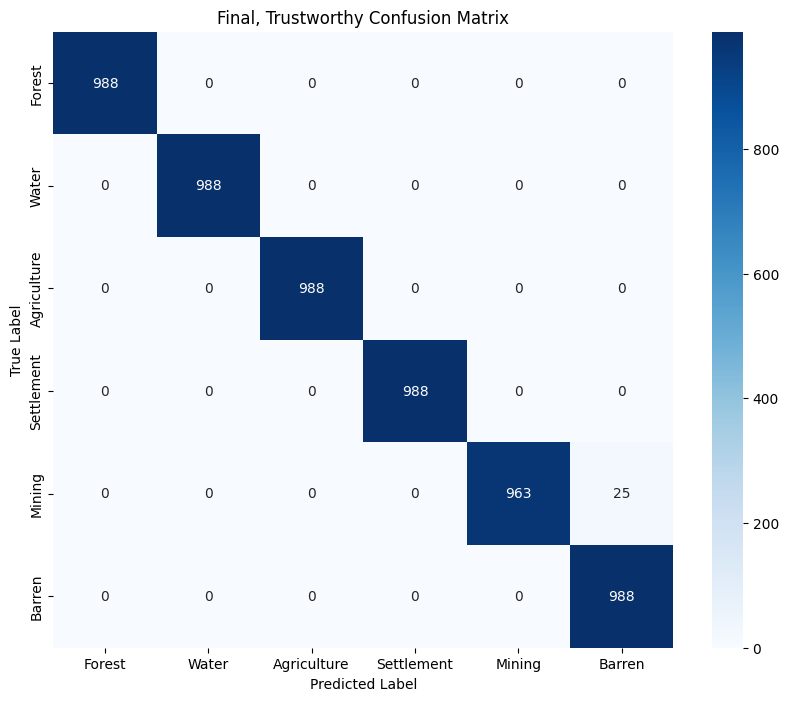


✅ Evaluation complete!


In [7]:
# --- STEP 7: BULLETPROOF MODEL EVALUATION ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Starting Bulletproof Evaluation ---")
print("Iterating through the test generator ONCE to get predictions and labels...")

all_predictions = []
all_true_labels = []

# Ensure the generator is at the start
testing_generator.on_epoch_end()

# Loop through every batch in the generator
for i in range(len(testing_generator)):
    # Get one batch of data and its true labels
    X_batch, y_batch_one_hot = testing_generator[i]

    # Make predictions on this single batch
    # Using predict_on_batch is efficient for manual loops
    preds_batch = model.predict_on_batch(X_batch)

    # Convert predictions (probabilities) and true labels (one-hot) to class indices
    preds_classes = np.argmax(preds_batch, axis=1)
    true_classes = np.argmax(y_batch_one_hot, axis=1)

    # Append the results from this batch to our master lists
    all_predictions.extend(preds_classes)
    all_true_labels.extend(true_classes)
    
    # Optional: Print progress so you know it's working
    if (i + 1) % 10 == 0:
        print(f"Processed batch {i + 1}/{len(testing_generator)}")

# Convert the lists to NumPy arrays for calculations
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# --- Final, Reliable Results ---
# Now that we have perfectly aligned arrays, calculate everything.
print("\n--- Final, Trustworthy Results ---")

# 1. Overall Accuracy Score
# This will be the TRUE accuracy of your model.
final_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nTRUE Test Accuracy: {final_accuracy:.4f}")

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(all_true_labels, all_predictions, target_names=CLASS_NAMES))

# 3. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Final, Trustworthy Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Close the file handle for the testing generator
testing_generator.close()

print("\n✅ Evaluation complete!")